In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import netCDF4
from scipy import stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
data_dir = '/Volumes/ATLAS/reanalysis/'
nc_file = 'NA_cape_1900-2010.nc'
months = pd.date_range('1900-01-01','2010-12-01',freq='MS')

In [3]:
#load nc file
nc_temp = xr.open_dataset(data_dir+nc_file)
temp = nc_temp['cape']


In [25]:
t_season='SON'
start_year = '1950-01-01'
end_year = '2010-12-01'
ext_e = -90
ext_w = -130
ext_n = 55
ext_s = 30

In [26]:
temp_1950=temp.sel(time=slice(start_year,end_year))
season_1950 = temp_1950.sel(time=temp_1950['time.season']==t_season)
jja_1950 = season_1950.groupby('time.year').mean(dim='time')

clim_30= temp.sel(time=slice('1981-01-01','2010-12-01'))
jja_30 = clim_30.groupby('time.season').mean(dim='time')

In [27]:
spatial_trend = temp.isel(time=1).copy(deep=True)

In [28]:
for i in np.arange(0,len(temp['latitude'])):
    for j in np.arange(0,len(temp['longitude'])):
        series = jja_1950[:,i,j]
        anom = series-jja_30.sel(season=t_season)[i,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(anom)),anom)
        spatial_trend[i,j]=slope
        #print(i)


In [29]:
#spatial_trend.to_dataset().to_netcdf(data_dir+'spatial_trends_c_'+t_season+'_'+start_year+'.nc')

/Users/gbromley/anaconda/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


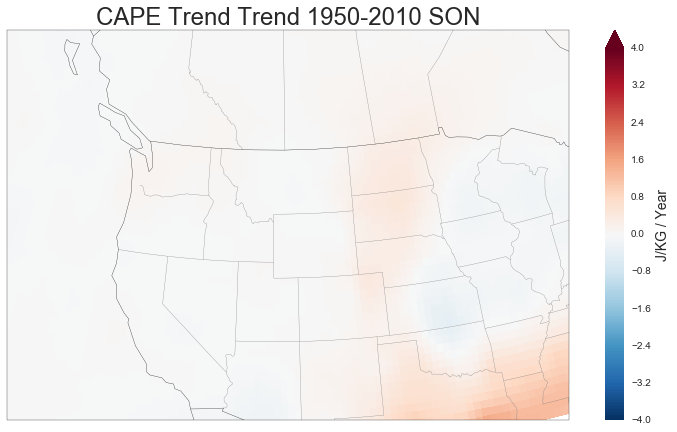

In [30]:
fig, ax = plt.subplots();
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-111.0,central_latitude=46.0,false_easting=0.0, false_northing=0.0, standard_parallels=(40.0, 50.0), globe=None))
ax.set_global()
test = spatial_trend.plot.pcolormesh(axes = ax, transform=ccrs.PlateCarree(),vmin=-4, vmax=4, cmap='RdBu_r')
#ax = plt.axes(projection=ccrs.LambertConformal())

ax.set_extent([ext_e, ext_w, ext_s, ext_n])
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
plt.title('CAPE Trend Trend 1950-2010 '+t_season,fontsize=24)
test.colorbar.set_label('J/KG / Year',fontsize=14)
fig.set_size_inches(13,7)
fig.set_dpi=1200.0
plt.savefig('CAPE_spatial_'+t_season+'_1950.png')
plt.show()

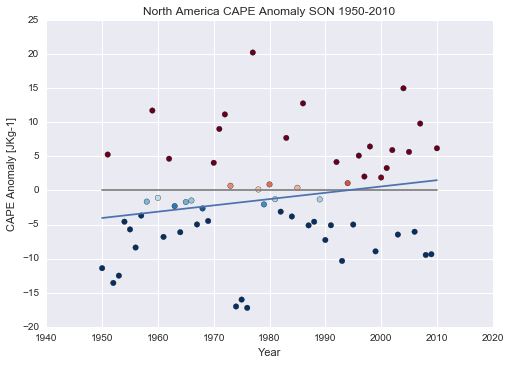

In [31]:
anom_series = jja_1950-jja_30.sel(season=t_season)
extent = anom_series.sel(latitude=np.arange(ext_s,ext_n,step=.5))
extent = extent.sel(longitude=np.arange(ext_w+360,ext_e+360,step=.5))
extent_series = extent.mean(dim=['latitude','longitude'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0,len(extent_series)),extent_series.values)
line = slope*np.arange(0,len(extent_series.values))+intercept



fig, ax = plt.subplots();
plt.scatter(extent_series['year'],extent_series.values, c=extent_series.values,vmin=-3,vmax=2,cmap='RdBu_r',s=30);
#trend = ax.plot(anom['time'],line)
base = np.zeros(len(extent_series.values))
ax.plot(extent_series['year'],base,c='grey')
ax.set_title('North America CAPE Anomaly '+t_season+' 1950-2010')
ax.set_xlabel('Year')
ax.set_ylabel('CAPE Anomaly [JKg-1]')
trend = ax.plot(extent_series['year'],line)
fig.savefig('2m_CAPE_anom_'+t_season+'_na_sp.png')

